###Bibliotecas

In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


###Ambiente

In [ ]:
input_txt = 'input-data.txt'

np.set_printoptions(suppress=True)
file1 = open(input_txt, 'r')
labels=[]
dim=-1

d1, d2, d3  = [31, 38, 43]

labeledDf1 = {}
labeledDf2 = {}

while True:
    line = file1.readline()

    if not line:
        break

    arrline = re.split(r'[ ]+', line.strip())
    if len(arrline) == 1:
        labels.append(arrline[0])
        dim+=1
        if dim<10:
            labeledDf1[labels[dim]] = np.zeros((d1,d2,d3))
        else:
            labeledDf2[labels[dim-10]] = np.zeros((d1,d2))
    else:
        if dim<10:
            idx, idy = np.array(arrline[0:2], dtype=int)
            labeledDf1[labels[dim]][idx-1][idy-1] = np.array(arrline[2:], dtype=float)
        else:
            idx, idy = np.array(arrline[0:2], dtype=int)
            labeledDf2[labels[dim-10]][idx-1][idy-1] = arrline[2]

file1.close()

matrix1 = []
for i in range(d1):
    for j in range(d2):
        for k in range(d3):
            array = []
            for v in labeledDf1.values():
                array.append(float(v[i][j][k]))
            matrix1.append([i+1,j+1,int(k+1),*array])

matrix2 = []
for i in range(d1):
    for j in range(d2):
        array = []
        for v in labeledDf2.values():
            array.append(float(v[i][j]))
        matrix2.append([i+1,j+1,*array])

df_input1 = pd.DataFrame(matrix1, columns=['X', 'Y', 'Z', *labels[:10]])
df_input2 = pd.DataFrame(matrix2, columns=['X', 'Y', *labels[10:]])

In [ ]:
df_input1

,X,Y,Z,thp,theta,pp,rtp,rv,wp,dn0,pi0,rcp,rrp
0,1,1,1,300.860779,300.746918,-0.193289,0.015203,0.015251,-0.009018,1.040897,969.020508,0.0,0.0
1,1,1,2,300.868958,300.746918,-0.201398,0.015194,0.015251,-0.014031,1.034775,967.021973,0.0,0.0
2,1,1,3,301.813080,301.718994,-0.210317,0.015575,0.015670,-0.021728,1.028059,964.825317,0.0,0.0
3,1,1,4,302.087097,302.019470,-0.218103,0.015445,0.015599,-0.028250,1.020713,962.411072,0.0,0.0
4,1,1,5,302.781036,302.734131,-0.224765,0.015474,0.015620,-0.034832,1.012631,959.757996,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50649,31,38,39,368.582428,368.589752,0.154782,0.000005,0.000004,0.006024,0.189218,528.877625,0.0,0.0
50650,31,38,40,378.118469,378.124237,0.002139,0.000004,0.000003,0.001509,0.167777,509.437836,0.0,0.0
50651,31,38,41,399.508545,399.512817,-0.159124,0.000006,0.000005,0.000666,0.144597,490.786438,0.0,0.0
50652,31,38,42,422.062836,422.062836,-0.286665,0.000011,0.000011,0.000000,0.125300,473.106506,0.0,0.0


In [ ]:
df_input2

,X,Y,rtgt,accpr,pcprr
0,1,1,0.936448,0.0,0.0
1,1,2,0.946728,0.0,0.0
2,1,3,0.956650,0.0,0.0
3,1,4,0.965879,0.0,0.0
4,1,5,0.974079,0.0,0.0
...,...,...,...,...,...
1173,31,34,0.994844,0.0,0.0
1174,31,35,0.994916,0.0,0.0
1175,31,36,0.995002,0.0,0.0
1176,31,37,0.995135,0.0,0.0


In [ ]:
output_txt = 'output-accpr-2d-data.txt'
df_output =  pd.read_csv(output_txt, sep='\s+', skiprows=1, header=None)
df_output.columns = ['X', 'Y', 'accpr_output']
df_output

,X,Y,accpr_output
0,1,1,0.0
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0
...,...,...,...
1173,31,34,0.0
1174,31,35,0.0
1175,31,36,0.0
1176,31,37,0.0


###Exploração da base

### df_input1

In [ ]:
df = df_input1.drop(columns=['X','Y','Z'])

# Inspecionar os primeiros registros
df.head()

# Verificar tipos de dados e valores ausentes
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50654 entries, 0 to 50653
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   thp     50654 non-null  float64
 1   theta   50654 non-null  float64
 2   pp      50654 non-null  float64
 3   rtp     50654 non-null  float64
 4   rv      50654 non-null  float64
 5   wp      50654 non-null  float64
 6   dn0     50654 non-null  float64
 7   pi0     50654 non-null  float64
 8   rcp     50654 non-null  float64
 9   rrp     50654 non-null  float64
dtypes: float64(10)
memory usage: 3.9 MB
None
thp      0
theta    0
pp       0
rtp      0
rv       0
wp       0
dn0      0
pi0      0
rcp      0
rrp      0
dtype: int64


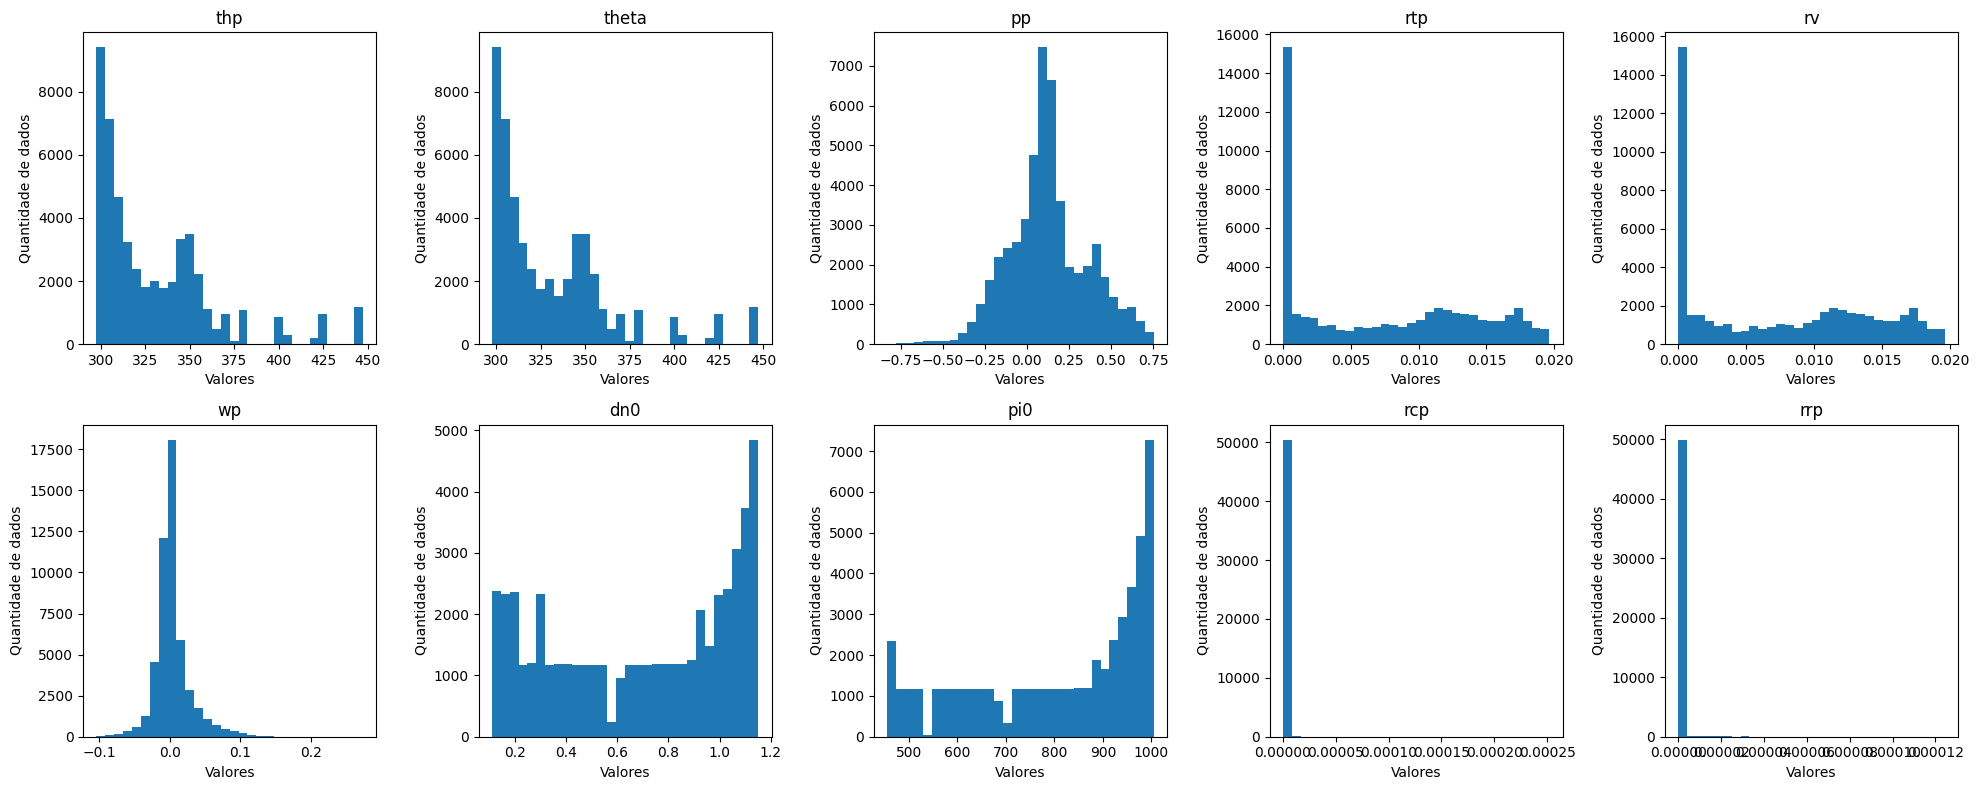

In [ ]:
# Distribuição de variáveis numéricas

# Criar uma figura com dez subplots (2 linhas, 5 colunas)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Gerar gráficos para 10 colunas (exemplo genérico, substitua pelas suas variáveis)
for i in range(10):
    linha = i // 5    # Definir a linha do subplot
    coluna = i % 5    # Definir a coluna do subplot

    axs[linha, coluna].hist(df_input1[f'{labels[i]}'], bins=30)  # Histograma
    axs[linha, coluna].set_title(f'{labels[i]}')
    axs[linha, coluna].set_xlabel('Valores')
    axs[linha, coluna].set_ylabel('Quantidade de dados')

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

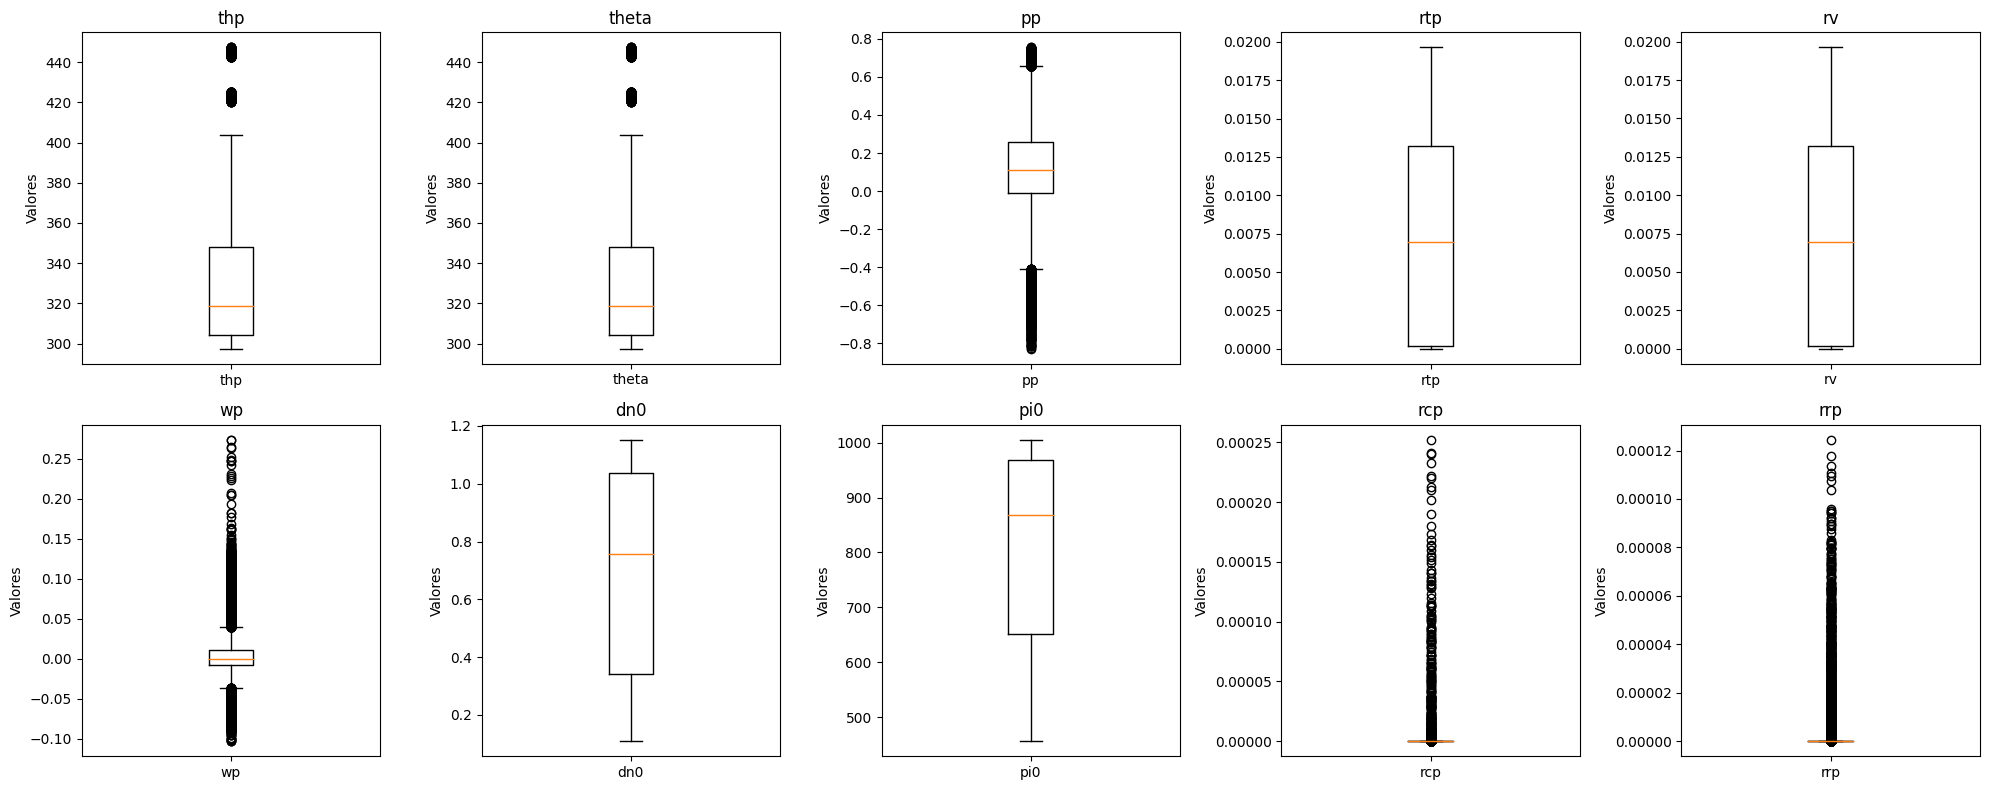

In [ ]:
# Criar uma figura com dez subplots (2 linhas, 5 colunas)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

# Gerar gráficos para 10 colunas (exemplo genérico, substitua pelas suas variáveis)
for i in range(10):
    linha = i // 5    # Definir a linha do subplot
    coluna = i % 5    # Definir a coluna do subplot

    axs[linha, coluna].boxplot(df_input1[f'{labels[i]}'], vert=True)  # Boxplot vertical
    axs[linha, coluna].set_title(f'{labels[i]}')
    axs[linha, coluna].set_ylabel('Valores')
    axs[linha, coluna].set_xticklabels([f'{labels[i]}'])  # Ajustar rótulo do eixo x para o nome da variável

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

### df_input2

In [ ]:
# Estatísticas descritivas input2
df = df_input2.drop(columns=['X','Y'])
df.describe()

# Verificar tipos de dados e valores ausentes
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rtgt    1178 non-null   float64
 1   accpr   1178 non-null   float64
 2   pcprr   1178 non-null   float64
dtypes: float64(3)
memory usage: 27.7 KB
None
rtgt     0
accpr    0
pcprr    0
dtype: int64


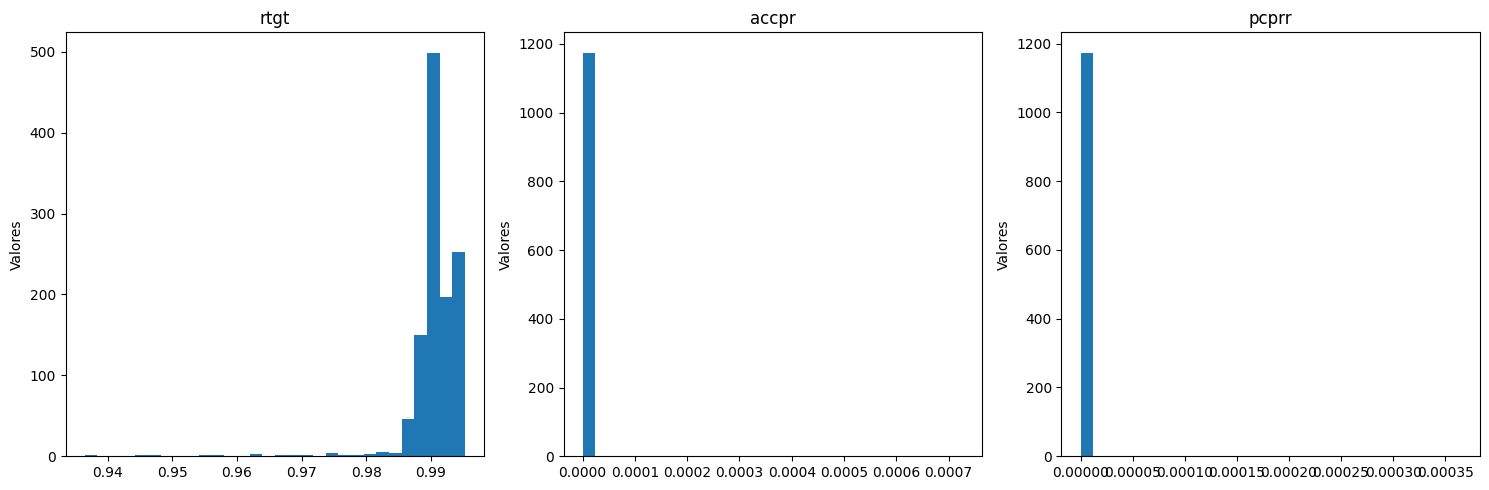

In [ ]:
# Criar uma figura com três subplots (1 linha, 3 colunas)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gerar gráficos para 3 colunas
for i in range(3):
    axs[i].hist(df_input2[f'{labels[i+10]}'], bins=30)  # Boxplot vertical
    axs[i].set_title(f'{labels[i+10]}')
    axs[i].set_ylabel('Valores')
    # axs[i].set_xticklabels([f'{labels[i+10]}'])  # Ajustar rótulo do eixo x para o nome da variável

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

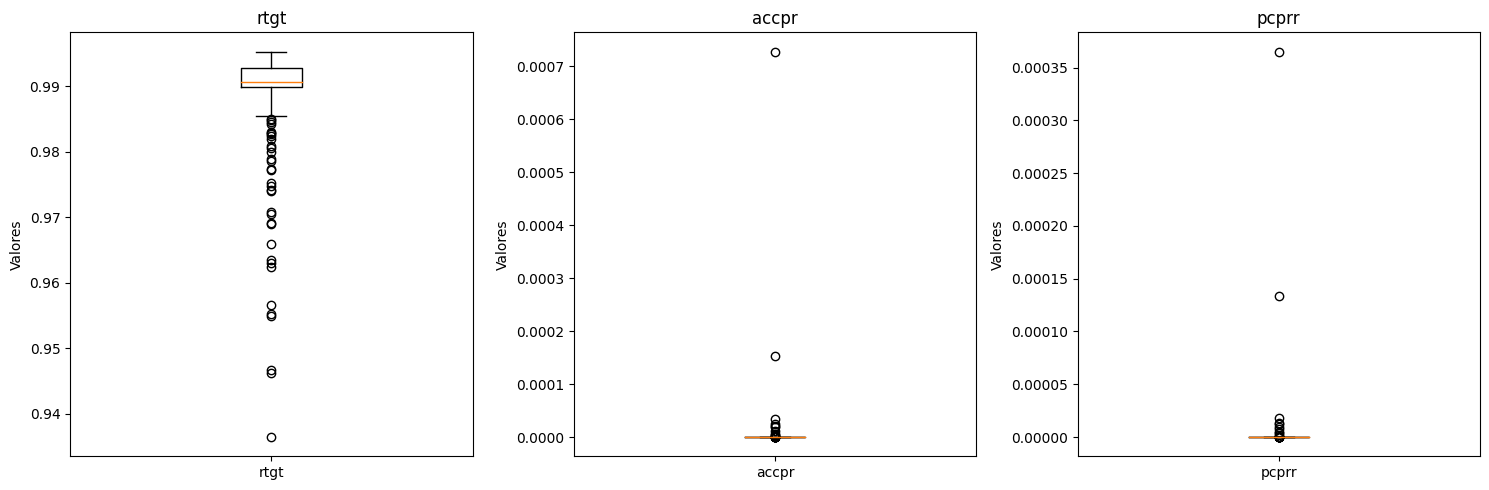

In [ ]:
# Criar uma figura com três subplots (1 linha, 3 colunas)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Gerar gráficos para 3 colunas
for i in range(3):
    axs[i].boxplot(df_input2[f'{labels[i+10]}'], vert=True)  # Boxplot vertical
    axs[i].set_title(f'{labels[i+10]}')
    axs[i].set_ylabel('Valores')
    axs[i].set_xticklabels([f'{labels[i+10]}'])  # Ajustar rótulo do eixo x para o nome da variável

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

### df_output

In [ ]:
# Estatísticas descritivas output
df = df_output.drop(columns=['X','Y'])

# Verificar tipos de dados e valores ausentes
print(df.info())
print(df.isnull().sum())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178 entries, 0 to 1177
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   accpr_output  1178 non-null   float64
dtypes: float64(1)
memory usage: 9.3 KB
None
accpr_output    0
dtype: int64
       accpr_output
count   1178.000000
mean       0.000002
std        0.000056
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.001719


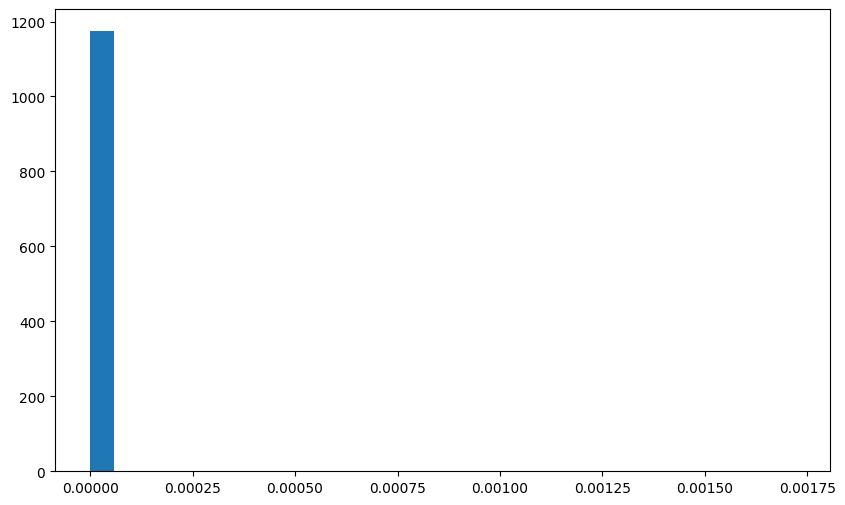

In [ ]:
# Definir o tamanho da figura (em polegadas)
plt.figure(figsize=(10, 6))

# Criar o histograma
plt.hist(df_output['accpr_output'], bins=30)

# Exibir o gráfico
plt.show()

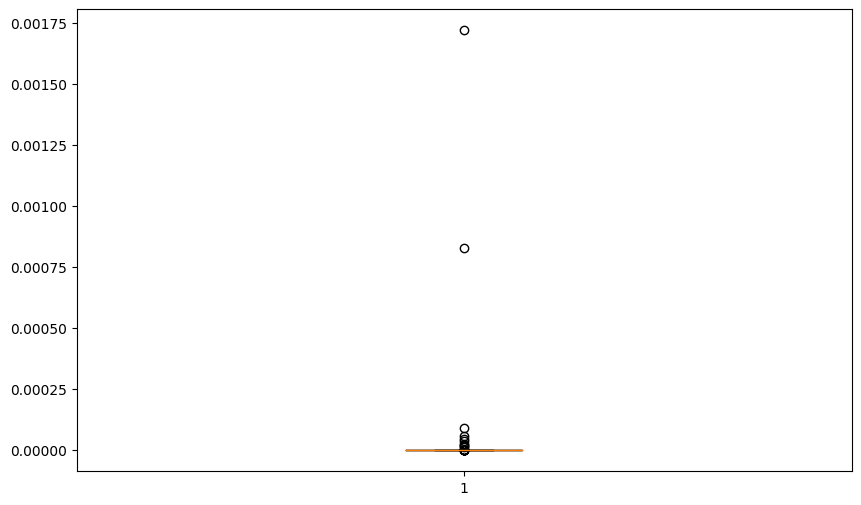

In [ ]:
# Definir o tamanho da figura (em polegadas)
plt.figure(figsize=(10, 6))

# Criar o boxplot
plt.boxplot(df_output['accpr_output'], vert=True)

# Exibir o gráfico
plt.show()

###Normalização

In [ ]:
#normalização df_input1
df_input1 = df_input1.drop(['X', 'Y', 'Z'], axis=1)
df_input1 = scaler.fit_transform(df_input1)
df_input1 = pd.DataFrame(df_input1, columns=[*labels[:10]])
df_input1

,thp,theta,pp,rtp,rv,wp,dn0,pi0,rcp,rrp
0,0.022759,0.021999,0.401225,0.774355,0.776803,0.250452,8.937760e-01,9.345950e-01,0.000385,0.000043
1,0.022814,0.021999,0.396106,0.773880,0.776803,0.237147,8.879024e-01,9.309522e-01,0.000385,0.000043
2,0.029113,0.028485,0.390475,0.793313,0.798163,0.216716,8.814596e-01,9.269483e-01,0.000385,0.000043
3,0.030941,0.030489,0.385560,0.786692,0.794538,0.199406,8.744124e-01,9.225478e-01,0.000385,0.000043
4,0.035571,0.035258,0.381354,0.788166,0.795600,0.181936,8.666594e-01,9.177120e-01,0.000385,0.000043
...,...,...,...,...,...,...,...,...,...,...
50649,0.474616,0.474655,0.620968,0.000103,0.000075,0.290377,7.673919e-02,1.323365e-01,0.000385,0.000043
50650,0.538243,0.538271,0.524602,0.000040,0.000033,0.278394,5.616987e-02,9.690313e-02,0.000385,0.000043
50651,0.680963,0.680978,0.422794,0.000157,0.000171,0.276156,3.393315e-02,6.290680e-02,0.000385,0.000043
50652,0.831451,0.831435,0.342275,0.000384,0.000446,0.274389,1.542064e-02,3.068119e-02,0.000385,0.000043


In [ ]:
#normalização df_input2
df_input2 = df_input2.drop(['X', 'Y'], axis=1)
df_input2 = scaler.fit_transform(df_input2)
df_input2 = pd.DataFrame(df_input2, columns=[*labels[10:]])
df_input2

,rtgt,accpr,pcprr
0,0.000000,0.0,0.0
1,0.174695,0.0,0.0
2,0.343302,0.0,0.0
3,0.500127,0.0,0.0
4,0.639472,0.0,0.0
...,...,...,...
1173,0.992333,0.0,0.0
1174,0.993554,0.0,0.0
1175,0.995007,0.0,0.0
1176,0.997274,0.0,0.0


In [ ]:
#normalização df_output
df_output = df_output.drop(['X', 'Y'], axis=1)
df_output = scaler.fit_transform(df_output)
df_output = pd.DataFrame(df_output, columns=['accpr_output'])
df_output

,accpr_output
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1173,0.0
1174,0.0
1175,0.0
1176,0.0


###Correlação

####Correlação por dataframe individualmente. (df_input1 e df_input2)

<Axes: >

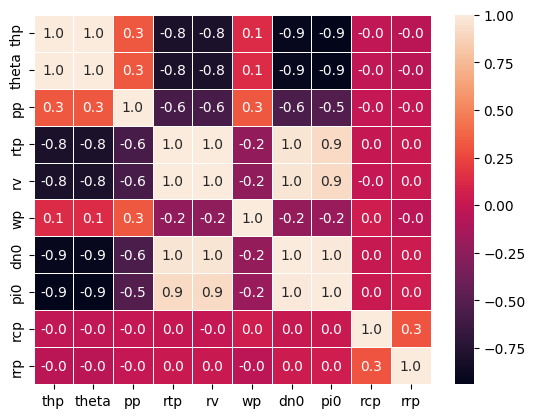

In [ ]:
correlation_df1 = df_input1.corr()
plot = sn.heatmap(correlation_df1, annot = True, fmt=".1f", linewidths=.6)
plot

<Axes: >

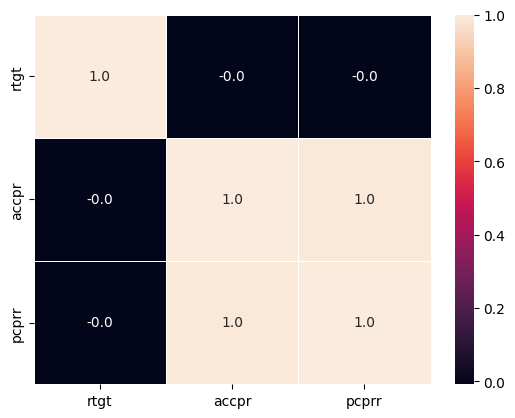

In [ ]:
correlation_df2 = df_input2.corr()
plot = sn.heatmap(correlation_df2, annot = True, fmt=".1f", linewidths=.6)
plot

#### Unindo variáveis 2D em um único dataframe para avaliar correlação. (df)

<Axes: >

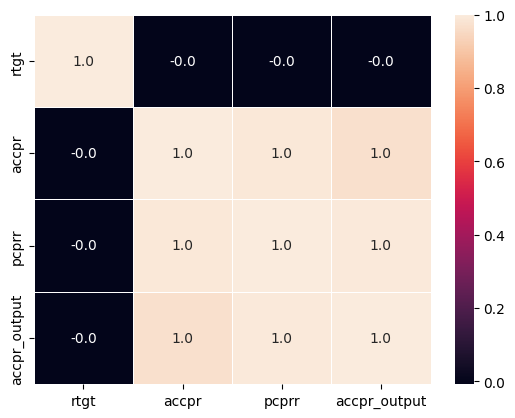

In [ ]:
df = df_input2.copy()
df['accpr_output'] = df_output['accpr_output']

correlation = df.corr()
plot = sn.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

###Testes 433 +1

In [ ]:
#df 433 + 1
df = df_input1
def group_into_vectors(df, window_size):
    # Inicializa um dicionário para armazenar os vetores agrupados
    grouped_data = {col: [] for col in df.columns}

    for col in df.columns:
        column_data = df[col].values
        num_vectors = len(column_data) // window_size

        # Divide a coluna em vetores de tamanho window_size
        for i in range(num_vectors):
            start_index = i * window_size
            end_index = start_index + window_size
            vector = column_data[start_index:end_index]
            grouped_data[col].append(vector)

    return grouped_data

# Define o tamanho do vetor (43 linhas)
window_size = 43
grouped_data = group_into_vectors(df, window_size)

# Cria DataFrames a partir dos dados agrupados
def create_dataframe_from_grouped_data(grouped_data):
    dfs = []
    for col, vectors in grouped_data.items():
        df_col = pd.DataFrame(vectors, columns=[f'{col}_{i+1}' for i in range(window_size)])
        dfs.append(df_col)

    # Concatena os DataFrames coluna a coluna
    return pd.concat(dfs, axis=1)

# Cria o novo DataFrame
df_grouped = create_dataframe_from_grouped_data(grouped_data)

print(df_grouped)

         thp_1     thp_2     thp_3     thp_4     thp_5     thp_6     thp_7  \
0     0.022759  0.022814  0.029113  0.030941  0.035571  0.038807  0.043115   
1     0.022450  0.022510  0.028851  0.030849  0.035555  0.038978  0.043384   
2     0.018031  0.018088  0.025245  0.027741  0.031940  0.035228  0.039065   
3     0.017824  0.017860  0.023748  0.026461  0.029876  0.032743  0.036022   
4     0.018562  0.018610  0.023701  0.026656  0.029512  0.031810  0.034427   
...        ...       ...       ...       ...       ...       ...       ...   
1173  0.005799  0.005870  0.007612  0.010214  0.014101  0.017870  0.022170   
1174  0.005686  0.005718  0.007180  0.009752  0.013534  0.017306  0.021517   
1175  0.005220  0.005271  0.006784  0.009332  0.012880  0.016480  0.020483   
1176  0.004961  0.004970  0.006381  0.008770  0.011894  0.015099  0.018760   
1177  0.003741  0.003741  0.005157  0.007289  0.009745  0.012513  0.016172   

         thp_8     thp_9    thp_10  ...    rrp_34    rrp_35    

In [ ]:
#unindo todos os df - rtgt	accpr	pcprr
df = df_grouped.copy()
df['rtgt'] = df_input2['rtgt']
df['accpr'] = df_input2['accpr']
df['pcprr'] = df_input2['pcprr']
df['accpr_output'] = df_output['accpr_output']
print(df)

         thp_1     thp_2     thp_3     thp_4     thp_5     thp_6     thp_7  \
0     0.022759  0.022814  0.029113  0.030941  0.035571  0.038807  0.043115   
1     0.022450  0.022510  0.028851  0.030849  0.035555  0.038978  0.043384   
2     0.018031  0.018088  0.025245  0.027741  0.031940  0.035228  0.039065   
3     0.017824  0.017860  0.023748  0.026461  0.029876  0.032743  0.036022   
4     0.018562  0.018610  0.023701  0.026656  0.029512  0.031810  0.034427   
...        ...       ...       ...       ...       ...       ...       ...   
1173  0.005799  0.005870  0.007612  0.010214  0.014101  0.017870  0.022170   
1174  0.005686  0.005718  0.007180  0.009752  0.013534  0.017306  0.021517   
1175  0.005220  0.005271  0.006784  0.009332  0.012880  0.016480  0.020483   
1176  0.004961  0.004970  0.006381  0.008770  0.011894  0.015099  0.018760   
1177  0.003741  0.003741  0.005157  0.007289  0.009745  0.012513  0.016172   

         thp_8     thp_9    thp_10  ...    rrp_38    rrp_39    

In [ ]:
#Divisão Treino e Teste
data_train = df.sample(frac=0.8,random_state=0)
data_test = df.drop(data_train.index)
data_train.columns

X_train = data_train.drop(['accpr_output'], axis=1).values
Y_train = data_train['accpr_output'].values

X_test = data_test.drop(['accpr_output'], axis=1).values
Y_test = data_test['accpr_output'].values

In [ ]:
np.random.seed(0)

In [ ]:
#MLP Regressor
#se quiser exibir cada epoca é só colocar verbose=True como parametro
mlp = MLPRegressor(random_state=0, max_iter=500, tol=0.000001, activation='tanh')
history = mlp.fit(X_train, Y_train)
mlp.out_activation_='relu' ##não permite numero negativo na saida da previsão
Y_pred = mlp.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test, Y_pred)

print(mlp.score(X_test, Y_test))
print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Absolute Percentage Error: {mape:.4f}')

0.9733609346210081
Mean Squared Error: 0.0001
Mean Absolute Error: 0.0050
Mean Absolute Percentage Error: 17698226673730.0547


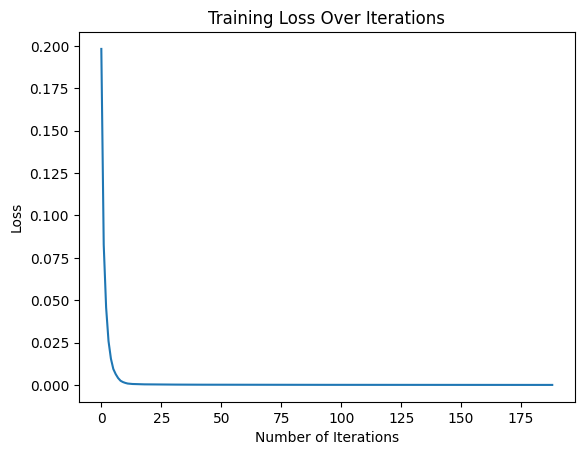

In [ ]:
#Gráficos

#Plot perda
plt.plot(range(history.n_iter_), history.loss_curve_)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Iterations")
plt.show()

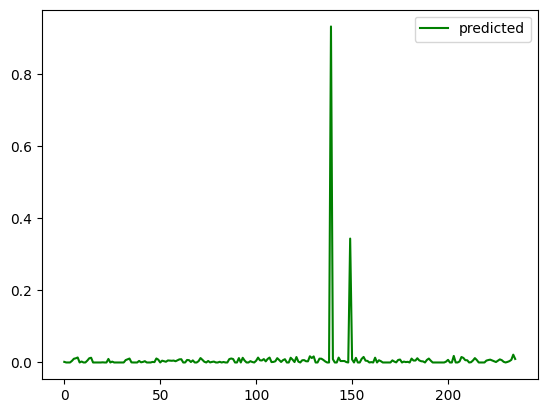

In [ ]:
# gráfico do valor previso
#(separei o valor previsto do valor real para ser mais facil visualizar)
plt.plot(Y_pred, label='predicted', color='green')
plt.legend()

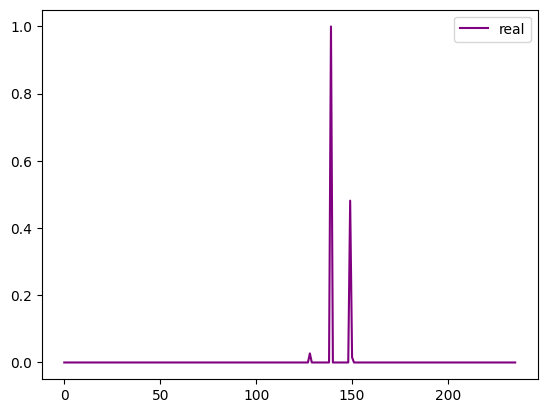

In [ ]:
# gráfico do valor previso
plt.plot(Y_test, label='real', color='purple')
plt.legend()

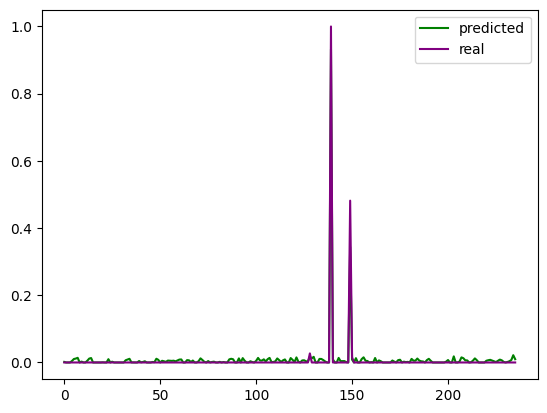

In [ ]:
# gráfico do valor previso
#(separei o valor previsto do valor real para ser mais facil visualizar)
plt.plot(Y_pred, label='predicted', color='green')
plt.plot(Y_test, label='real', color='purple')
plt.legend()